# Modelo Auto-Arima

In [95]:
import pandas as pd
import numpy as np
import seaborn as sns

from pmdarima.arima import auto_arima
from pmdarima import arima
from pmdarima.utils import tsdisplay, autocorr_plot, decomposed_plot, plot_acf, plot_pacf
from matplotlib.pyplot import rcParams
rcParams['figure.figsize']=20,6
from pmdarima.arima import ADFTest
from statsmodels.tsa.statespace.sarimax import SARIMAX


from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, train_test_split
import pmdarima as pm
import matplotlib as mpl
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
import matplotlib.pyplot as plt
import math

In [2]:
df = pd.read_csv(r'C:\Users\gabri\Desktop\Git - Tcc\df_casos_leves')
df

C:\Users\gabri\AppData\Local\Temp\ipykernel_1540\3450452656.py:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r'C:\Users\gabri\Desktop\Git - Tcc\df_casos_leves')


,Unnamed: 0,sexo,data_notificacao,idade,data_inicio_sintomas,sintomas,outros_sintomas,classificacao_final,resultado_final,bairro,...,SYMPTOM_BODY_PAIN,SYMPTOM_DIARRHEA,SYMPTOM_RUNNY_NOSE,SYMPTOM_NOSE_CONGESTION,SYMPTOM_WEAKNESS,SYMPTOM_ANOSMIA_OR_HYPOSMIA,SYMPTOM_NAUSEA,SYMPTOM_LACK_OF_APPETITE,SYMPTOM_ABDOMINAL_PAIN,SYMPTOM_CONSCIOUSNESS_DEGRADATION
0,0,1,2020-01-12,28,2020-01-12,['ASSINTOMÁTICO'],[],7,4,SANCHO,...,0,0,0,0,0,0,0,0,0,0
1,1,0,2020-01-20,36,2020-01-20,['ASSINTOMÁTICO'],[],7,2,ROSARINHO,...,0,0,0,0,0,0,0,0,0,0
2,2,0,2020-01-20,45,2020-01-20,['ASSINTOMÁTICO'],[],7,2,CASA AMARELA,...,0,0,0,0,0,0,0,0,0,0
3,3,1,2020-01-20,58,2020-01-20,['ASSINTOMÁTICO'],[],7,2,ROSARINHO,...,0,0,0,0,0,0,0,0,0,0
4,4,0,2020-01-22,33,2020-01-22,['ASSINTOMÁTICO'],[],7,2,IPUTINGA,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
889840,889840,0,2022-01-23,27,2022-01-23,['OUTROS'],['PRÉ-CIRÚRGICO'],7,4,CAMPO GRANDE,...,0,0,0,0,0,0,0,0,0,0
889841,889841,1,2022-01-23,26,2022-01-23,['OUTROS'],['PRÉ-CIR´ÚRGICO'],7,4,IBURA,...,0,0,0,0,0,0,0,0,0,0
889842,889842,0,2022-01-23,38,2022-01-23,['ASSINTOMÁTICO'],['0'],7,4,COHAB,...,0,0,0,0,0,0,0,0,0,0
889843,889843,0,2022-01-23,26,2022-01-16,"['CORIZA', 'DOR DE CABEÇA', 'DOR DE GARGANTA',...",['0'],7,4,POCO,...,0,0,1,0,0,0,0,0,0,0


In [62]:
df_st = df['data_notificacao'].value_counts().rename_axis('Data_notificacao').to_frame('N_casos')
df_st.sort_index(inplace = True)
df_st

,N_casos
Data_notificacao,
2020-01-12,1
2020-01-20,3
2020-01-22,1
2020-01-24,1
2020-01-25,1
...,...
2022-06-17,1327
2022-06-18,550
2022-06-19,552


In [31]:
df_st2 = df_st
df_st2['data_notificacao'] = df_st.index
df_st2['data_notificacao'] = pd.to_datetime(df_st2['data_notificacao'])
df_st2

,N_casos,data_notificacao
Data_notificacao,,
2020-01-12,1,2020-01-12
2020-01-20,3,2020-01-20
2020-01-22,1,2020-01-22
2020-01-24,1,2020-01-24
2020-01-25,1,2020-01-25
...,...,...
2022-06-17,1327,2022-06-17
2022-06-18,550,2022-06-18
2022-06-19,552,2022-06-19


<AxesSubplot:xlabel='Data_notificacao'>

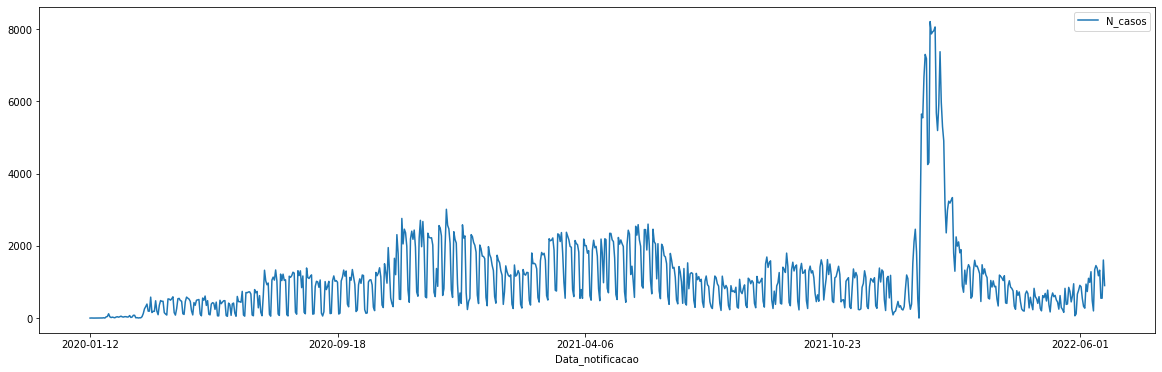

In [4]:
df_st.plot(figsize=(20,6))

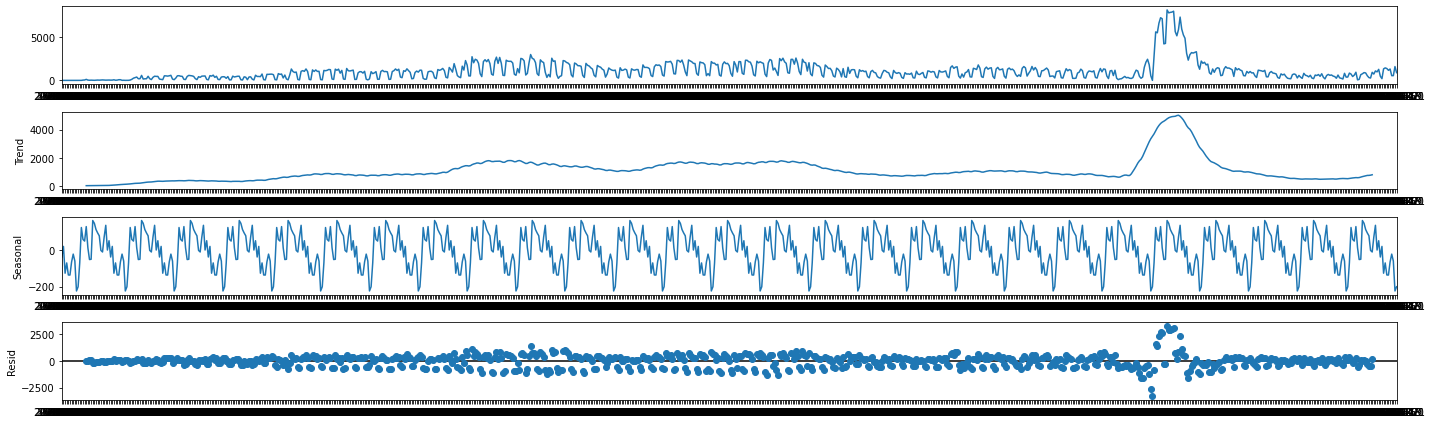

In [5]:
df_decomp = tsa.seasonal_decompose(df_st, period = 30)
df_decomp.plot();

Diferenciando a série para deixa-la estacionária

In [6]:
df_dif = df_st.diff(1)

<AxesSubplot:xlabel='Data_notificacao'>

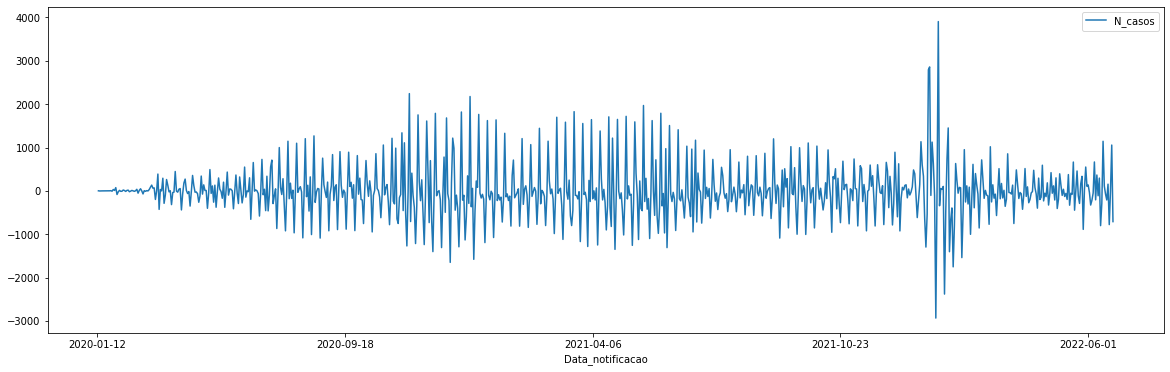

In [7]:
df_dif.plot(figsize=(20,6))

<AxesSubplot:ylabel='Frequency'>

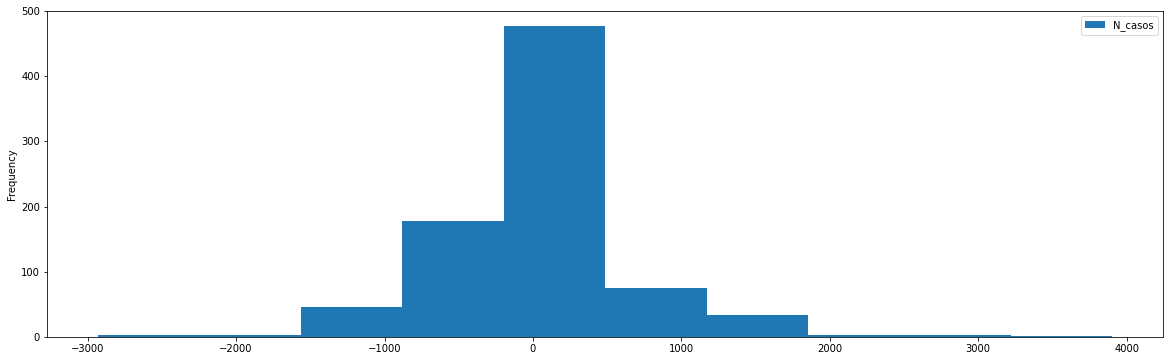

In [8]:
df_dif.plot.hist()

In [9]:
test, pvalue, lags, obs, critic, ic = tsa.stattools.adfuller(df_st, regression='ct')
print('ADF :', test)
print('P-Value: ',pvalue)
print('Num Of Lags: ',lags)
print('Num Of Observations Used For ADF Regression: ', ic)
print('Critical Values : ', critic )


ADF : -4.316131019349432
P-Value:  0.002969582869138721
Num Of Lags:  21
Num Of Observations Used For ADF Regression:  11755.976597434807
Critical Values :  {'1%': -3.970145331184678, '5%': -3.4159991116531545, '10%': -3.1302922371049116}


In [61]:
df_st

,N_casos,data_notificacao
Data_notificacao,,
2020-01-12,1,2020-01-12
2020-01-20,3,2020-01-20
2020-01-22,1,2020-01-22
2020-01-24,1,2020-01-24
2020-01-25,1,2020-01-25
...,...,...
2022-06-17,1327,2022-06-17
2022-06-18,550,2022-06-18
2022-06-19,552,2022-06-19


In [44]:
data_inicio = df_st2['data_notificacao'][0] + pd.Timedelta(days = 0)
data_fim_treino = data_inicio + pd.Timedelta(days = int(90*0.7))
data_fim = data_inicio + pd.Timedelta(days = 90)

treino = df_st[(df_st2['data_notificacao'] >= data_inicio) & (df_st2['data_notificacao'] <= data_fim_treino )]
teste = df_st[(df_st2['data_notificacao'] >= data_fim_treino) & (df_st2['data_notificacao'] <= data_fim )]
treino

,N_casos,data_notificacao
Data_notificacao,,
2020-01-12,1,2020-01-12
2020-01-20,3,2020-01-20
2020-01-22,1,2020-01-22
2020-01-24,1,2020-01-24
2020-01-25,1,2020-01-25
2020-02-18,1,2020-02-18
2020-03-02,1,2020-03-02
2020-03-06,1,2020-03-06
2020-03-07,1,2020-03-07


Criando função para aplicação do modelo!

In [99]:
def apl_sarima (df, m, d):

    for i in range (0,821, d):
        data_inicio = df['data_notificacao'][0] + pd.Timedelta(days = i)
        data_fim_treino = data_inicio + pd.Timedelta(days = int(d*0.7))
        data_fim = data_inicio + pd.Timedelta(days = d)

        treino = df[(df['data_notificacao'] >= data_inicio) & (df['data_notificacao'] <= data_fim_treino )]['N_casos']
        teste = df[(df['data_notificacao'] > data_fim_treino) & (df['data_notificacao'] <= data_fim )]['N_casos']

        # treino = df_st.iloc[:int(len(df_st) * 0.7)]
        # teste = df_st.iloc[int(len(df_st) * 0.7):]

        print('Inicio do periodo: ', data_inicio)
        print('Final do periodo: ', data_fim)

        stepwise=auto_arima(df['N_casos'],
                        start_p=0,
                        start_q=0,
                        d=0,
                        max_p=6,
                        max_q=6,
                        max_d=2,
                        start_P=0,
                        start_Q=0,
                        D=1,
                        max_P=6, max_D=2, max_Q=6, max_order=5,
                        m=m,
                        seasonal=True,
                        trace=True,
                        error_action='ignore',suppress_warnings=True,
                        stepwise=True)

        # print('#'*40)
        # print('AIC: ',stepwise.aic())
        # print('BIC: ',stepwise.bic())
        # print('#'*40)

        stepwise.fit(treino)
        # print('#'*40)
        # print(stepwise.summary())
        # print('#'*40)
        # print( stepwise.plot_diagnostics(); )
        # print('#'*40)

        previsao=stepwise.predict(len(teste))
        previsao=pd.DataFrame(previsao)
        previsao['index'] = teste.index
        previsao = previsao.set_index('index')

        print('#'*40)
        print('SARIMA model Results')
        print('R2' ,r2_score(teste, previsao))
        print('MSE' , mean_squared_error(teste, previsao))
        print('RMSE', math.sqrt(mean_squared_error(teste, previsao)))
        print('MAE', mean_absolute_error(teste, previsao))
        #print('MAPE', mean_absolute_percentage_error(df_sarima.predict_in_sample(), df_st2))
        print('#'*40)   

In [123]:
def apl_model(df, d, m):
        # data_inicio = df['data_notificacao'][0] + pd.Timedelta(days = i)
        # data_fim_treino = data_inicio + pd.Timedelta(days = int(d*0.7))
        # data_fim = data_inicio + pd.Timedelta(days = d)

        # treino = df[(df['data_notificacao'] >= data_inicio) & (df['data_notificacao'] <= data_fim_treino )]['N_casos']
        # teste = df[(df['data_notificacao'] > data_fim_treino) & (df['data_notificacao'] <= data_fim )]['N_casos']

        treino = df_st.iloc[:int(len(df_st) * 0.7)]
        teste = df_st.iloc[int(len(df_st) * 0.7):]

        # print('Inicio do periodo: ', data_inicio)
        # print('Final do periodo: ', data_fim)

        stepwise=auto_arima(df['N_casos'],
                        start_p=0,
                        start_q=0,
                        d=0,
                        max_p=22,
                        max_q=18,
                        max_d=2,
                        start_P=0,
                        start_Q=0,
                        D=1,
                        max_P=22, max_D=2, max_Q=18, max_order=5,
                        m=m,
                        seasonal=True,
                        trace=True,
                        error_action='ignore',suppress_warnings=True,
                        stepwise=True)

        # print('#'*40)
        # print('AIC: ',stepwise.aic())
        # print('BIC: ',stepwise.bic())
        # print('#'*40)

        stepwise.fit(treino)
        # print('#'*40)
        print(stepwise.summary())
        # print('#'*40)
        stepwise.plot_diagnostics();
        # print('#'*40)

        previsao=stepwise.predict(len(teste))
        previsao=pd.DataFrame(previsao)
        previsao['index'] = teste.index
        previsao = previsao.set_index('index')

        print('#'*40)
        print('SARIMA model Results')
        print('R2' ,r2_score(teste, previsao))
        print('MSE' , mean_squared_error(teste, previsao))
        print('RMSE', math.sqrt(mean_squared_error(teste, previsao)))
        print('MAE', mean_absolute_error(teste, previsao))
        #print('MAPE', mean_absolute_percentage_error(df_sarima.predict_in_sample(), df_st2))
        print('#'*40) 

        pd.concat([df,previsao],
          axis=1).plot(linewidth=2,
                       figsize=(20,7),
                       color=['g','r'])
        plt.legend(['Consumo de energia','Previsões'], fontsize=15)
        plt.xlabel('Período', size=15)
        plt.title('Previsões X Real',size=15)
        plt.show();

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=12891.075, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=12153.379, Time=0.54 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=12537.439, Time=0.65 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=12889.244, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[7] intercept   : AIC=12239.849, Time=0.07 sec
 ARIMA(1,0,0)(2,1,0)[7] intercept   : AIC=12081.606, Time=1.13 sec
 ARIMA(1,0,0)(3,1,0)[7] intercept   : AIC=12063.691, Time=2.31 sec
 ARIMA(1,0,0)(4,1,0)[7] intercept   : AIC=12046.211, Time=4.43 sec
 ARIMA(1,0,0)(5,1,0)[7] intercept   : AIC=12029.776, Time=8.16 sec
 ARIMA(1,0,0)(6,1,0)[7] intercept   : AIC=12027.125, Time=10.48 sec
 ARIMA(1,0,0)(7,1,0)[7] intercept   : AIC=12022.085, Time=12.65 sec
 ARIMA(1,0,0)(8,1,0)[7] intercept   : AIC=12021.329, Time=19.82 sec
 ARIMA(1,0,0)(9,1,0)[7] intercept   : AIC=12015.336, Time=64.88 sec
 ARIMA(1,0,0)(10,1,0)[7] intercept   : AIC=12017.277, Time=74.20 sec
 ARIMA(1,0,0)

C:\Users\gabri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


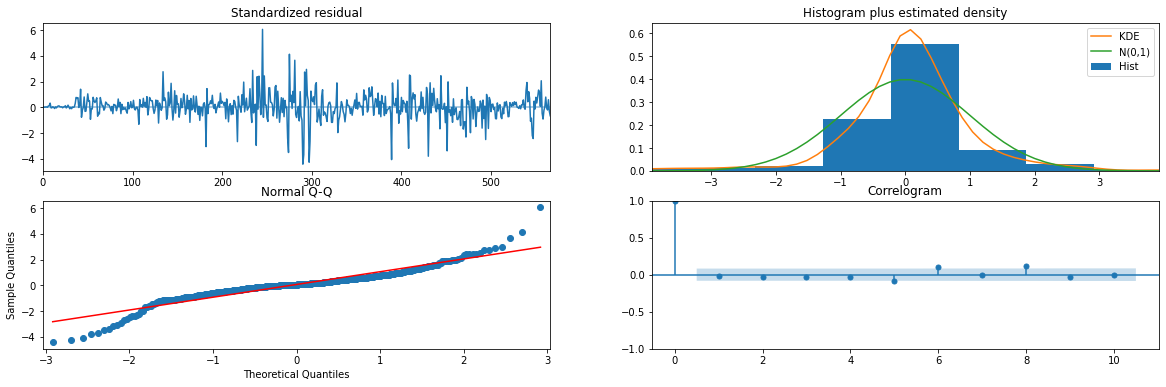

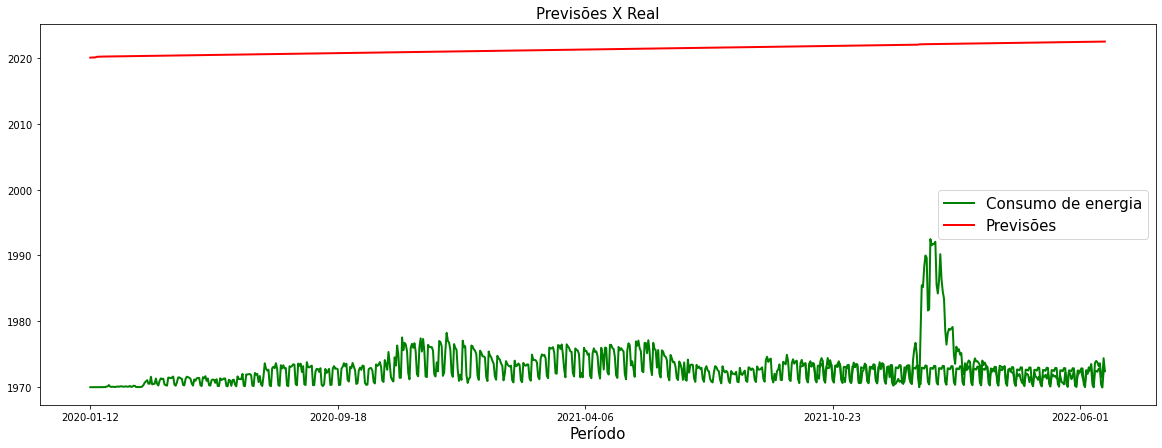

In [124]:
apl_model(df_st2, 1, 7)

### APLICANDO AUTO-SARIMA

In [100]:
apl_sarima(df_st2, 1, 30)

Inicio do periodo:  2020-02-11 00:00:00
Final do periodo:  2020-03-12 00:00:00
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=13819.367, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=12800.443, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=13181.204, Time=0.26 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=14381.101, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=12800.383, Time=0.06 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=12735.269, Time=0.10 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=12731.592, Time=0.15 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=12715.893, Time=0.24 sec
 ARIMA(6,0,0)(0,0,0)[0] intercept   : AIC=12511.985, Time=0.30 sec
 ARIMA(6,0,1)(0,0,0)[0] intercept   : AIC=12497.820, Time=0.45 sec
 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=12648.884, Time=0.87 sec
 ARIMA(6,0,2)(0,0,0)[0] intercept   : AIC=12310.291, Time=1.20 sec
 ARIMA(5,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.15 sec
 ARIMA(6,0,3)

C:\Users\gabri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=13181.204, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=14381.101, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=12800.383, Time=0.06 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=12735.269, Time=0.10 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=12731.592, Time=0.14 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=12715.893, Time=0.18 sec
 ARIMA(6,0,0)(0,0,0)[0] intercept   : AIC=12511.985, Time=0.26 sec
 ARIMA(6,0,1)(0,0,0)[0] intercept   : AIC=12497.820, Time=0.39 sec
 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=12648.884, Time=0.85 sec
 ARIMA(6,0,2)(0,0,0)[0] intercept   : AIC=12310.291, Time=1.27 sec
 ARIMA(5,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.08 sec
 ARIMA(6,0,3)(0,0,0)[0] intercept   : AIC=12320.518, Time=1.32 sec
 ARIMA(5,0,3)(0,0,0)[0] intercept   : AIC=12377.644, Time=1.14 sec
 ARIMA(6,0,2)(0,0,0)[0]             : AIC=12315.816, Time=0.69 sec

Best model:  ARIMA(6,0,2)(0,0,0)[0] intercept
Total fit time: 7.781

KeyboardInterrupt: 

Periodicidade de 7 Dias

In [63]:
stepwise=auto_arima(df_st,
                    start_p=0,
                    start_q=0,
                    d=0,
                    max_p=6,
                    max_q=6,
                    max_d=2,
                    start_P=1,
                    start_Q=1,
                    D=1,
                    max_P=2, max_D=1, max_Q=2, max_order=5,
                    m=1,
                    seasonal=True,
                    trace=True,
                    error_action='ignore',suppress_warnings=True,
                    stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=13819.367, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=12800.443, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=13181.204, Time=0.26 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=14381.101, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=12800.383, Time=0.07 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=12735.269, Time=0.11 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=12731.592, Time=0.16 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=12715.893, Time=0.21 sec
 ARIMA(6,0,0)(0,0,0)[0] intercept   : AIC=12511.985, Time=0.31 sec
 ARIMA(6,0,1)(0,0,0)[0] intercept   : AIC=12497.820, Time=0.43 sec
 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=12648.884, Time=0.87 sec
 ARIMA(6,0,2)(0,0,0)[0] intercept   : AIC=12310.291, Time=1.25 sec
 ARIMA(5,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.17 sec
 ARIMA(6,0,3)(0,0,0)[0] intercept   : AIC=12320.518, Time=1.36 sec
 ARIMA(5,0,3)(0,0,0)[0] i

In [64]:
print('AIC: ',stepwise.aic())
print('BIC: ',stepwise.bic())

AIC:  12310.290967839339
BIC:  12357.396198933864


Divindindo em treino (70%) e teste(30%)

In [65]:
treino = df_st.iloc[:int(len(df_st) * 0.7)]
teste = df_st.iloc[int(len(df_st) * 0.7):]

In [66]:
stepwise.fit(treino)

ARIMA(order=(6, 0, 2), scoring_args={}, suppress_warnings=True)

In [67]:
stepwise.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  574
Model:               SARIMAX(6, 0, 2)   Log Likelihood               -4175.344
Date:                Mon, 07 Nov 2022   AIC                           8370.688
Time:                        21:41:06   BIC                           8414.214
Sample:                             0   HQIC                          8387.666
                                - 574                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     93.6570     33.782      2.772      0.006      27.446     159.868
ar.L1          1.0700      0.041     26.234      0.000       0.990       1.150
ar.L2         -0.8071      0.060    -13.431      0.000      -0.925      -0.689
ar.L3          0.2701      0.065      4.146      0.000       0.142       0.398
ar.L4          0.0842      0.062      1.365      0.172      -0.037       0.205
ar.L5         -0.3174      0.056     -5.667      0.000      -0.427      -0.208
ar.L6          0.6044      0.039     15.437      0.000       0.528       0.681
ma.L1         -0.8267      0.033    -25.428      0.000      -0.890      -0.763
ma.L2          0.6111      0.035     17.286      0.000       0.542       0.680
sigma2      1.335e+05   6361.909     20.991      0.000    1.21e+05    1.46e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               206.34
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               3.33   Skew:                             0.37
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

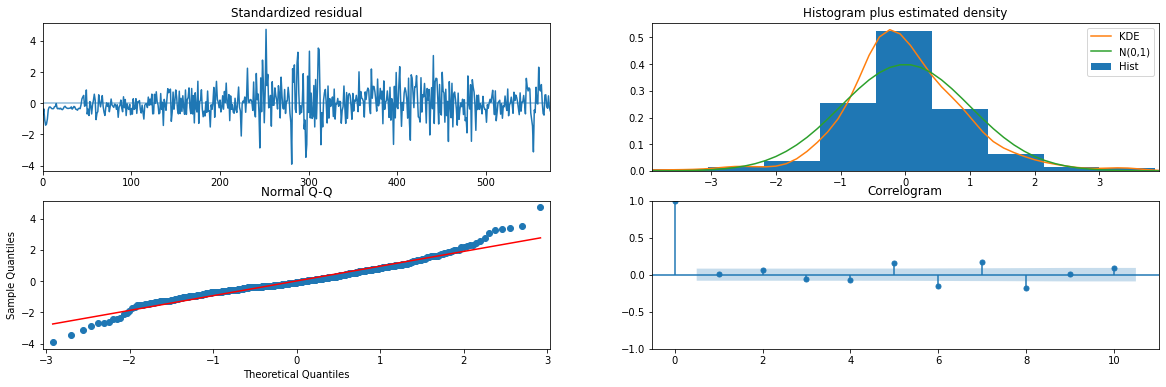

In [68]:
stepwise.plot_diagnostics();

In [69]:
previsao=stepwise.predict(247)
previsao=pd.DataFrame(previsao)
previsao['index'] = teste.index
previsao = previsao.set_index('index')
previsao

C:\Users\gabri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


,0
index,
2021-09-27,1085.577178
2021-09-28,1548.304558
2021-09-29,1370.303909
2021-09-30,1363.336659
2021-10-01,1166.232270
...,...
2022-06-17,1015.311302
2022-06-18,1343.702320
2022-06-19,1388.168618


<Figure size 1440x360 with 0 Axes>

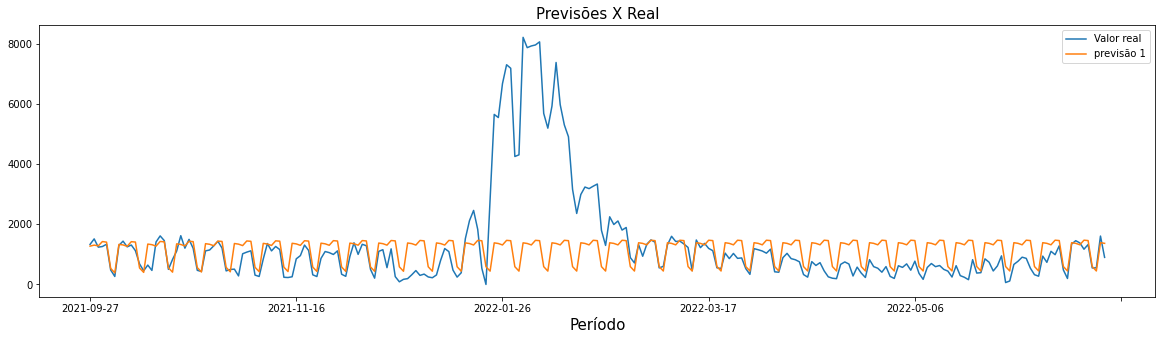

In [93]:
plt.figure(figsize=(20,5))
pd.concat([teste,previsao],axis=1).plot(figsize=(20,5))
plt.xlabel('')
plt.title('Previsões X Real',size=15)
plt.xlabel("Período", size=15)
plt.legend(['Valor real','previsão 1']);

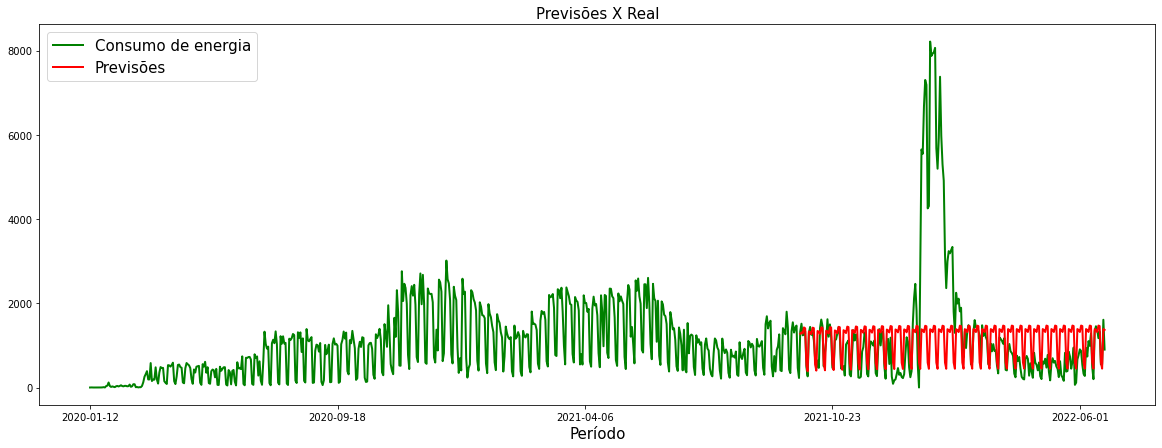

In [94]:
pd.concat([df_st,previsao],
          axis=1).plot(linewidth=2,
                       figsize=(20,7),
                       color=['g','r'])
plt.legend(['Consumo de energia','Previsões'], fontsize=15)
plt.xlabel('Período', size=15)
plt.title('Previsões X Real',size=15)
plt.show();

## Aplicando o modelo para periodicidade de 1 dia

In [104]:
stepwise2 , previsao2 = apl_arima(df_st, 1)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=13819.367, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=12800.443, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=13181.204, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=14381.101, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=12800.383, Time=0.06 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=12735.269, Time=0.10 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=12731.592, Time=0.13 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=12715.893, Time=0.18 sec
 ARIMA(6,0,0)(0,0,0)[0] intercept   : AIC=12511.985, Time=0.26 sec
 ARIMA(6,0,1)(0,0,0)[0] intercept   : AIC=12497.820, Time=0.39 sec
 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=12648.884, Time=0.88 sec
 ARIMA(6,0,2)(0,0,0)[0] intercept   : AIC=12310.291, Time=1.16 sec
 ARIMA(5,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.15 sec
 ARIMA(6,0,3)(0,0,0)[0] intercept   : AIC=12320.518, Time=1.22 sec
 ARIMA(5,0,3)(0,0,0)[0] i

C:\Users\gabri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [105]:
stepwise2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  574
Model:               SARIMAX(6, 0, 2)   Log Likelihood               -4175.344
Date:                Fri, 04 Nov 2022   AIC                           8370.688
Time:                        16:13:42   BIC                           8414.214
Sample:                             0   HQIC                          8387.666
                                - 574                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     93.6570     33.782      2.772      0.006      27.446     159.868
ar.L1          1.0700      0.041     26.234      0.000       0.990       1.150
ar.L2         -0.8071      0.060    -13.431      0.000      -0.925      -0.689
ar.L3          0.2701      0.065      4.146      0.000       0.142       0.398
ar.L4          0.0842      0.062      1.365      0.172      -0.037       0.205
ar.L5         -0.3174      0.056     -5.667      0.000      -0.427      -0.208
ar.L6          0.6044      0.039     15.437      0.000       0.528       0.681
ma.L1         -0.8267      0.033    -25.428      0.000      -0.890      -0.763
ma.L2          0.6111      0.035     17.286      0.000       0.542       0.680
sigma2      1.335e+05   6361.909     20.991      0.000    1.21e+05    1.46e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               206.34
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               3.33   Skew:                             0.37
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

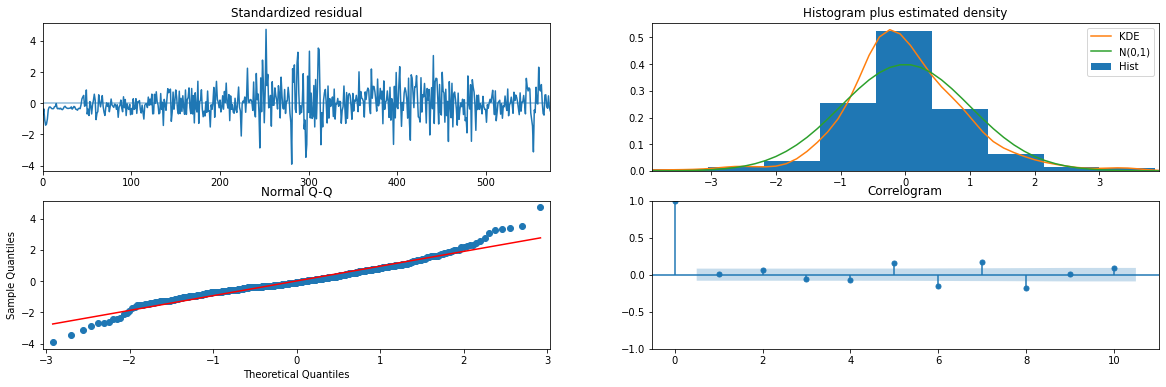

In [106]:
stepwise2.plot_diagnostics();

<Figure size 1440x360 with 0 Axes>

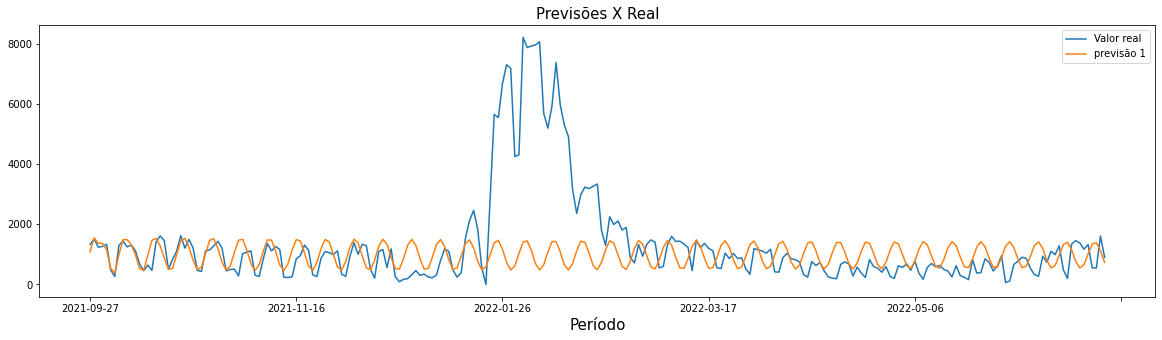

In [107]:
plt.figure(figsize=(20,5))
pd.concat([teste,previsao2],axis=1).plot(figsize=(20,5))
plt.xlabel('')
plt.title('Previsões X Real',size=15)
plt.xlabel("Período", size=15)
plt.legend(['Valor real','previsão 1']);

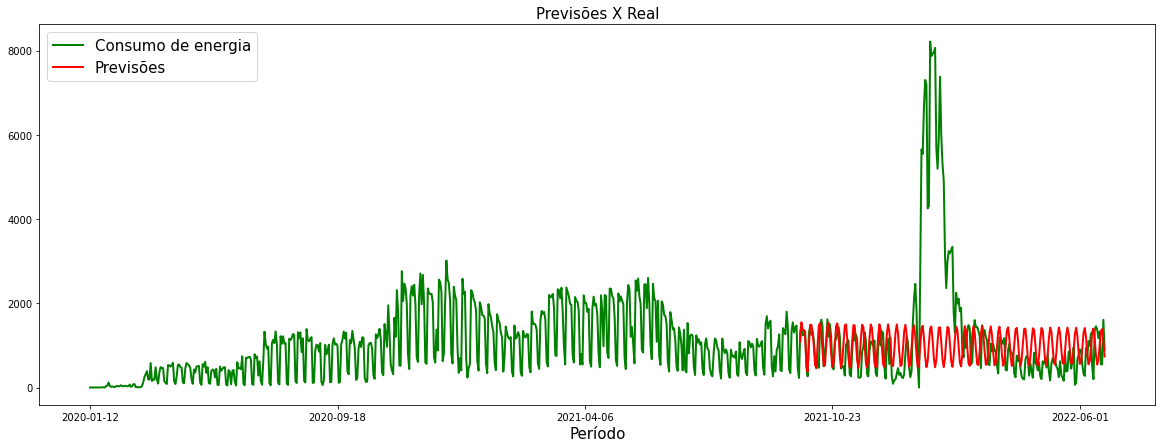

In [108]:
pd.concat([df_st,previsao2],
          axis=1).plot(linewidth=2,
                       figsize=(20,7),
                       color=['g','r'])
plt.legend(['Consumo de energia','Previsões'], fontsize=15)
plt.xlabel('Período', size=15)
plt.title('Previsões X Real',size=15)
plt.show();

In [13]:
stepwise2 , previsao2 = apl_arima(df_st, 15)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,1,1)[15] intercept   : AIC=inf, Time=3.03 sec
 ARIMA(0,0,0)(0,1,0)[15] intercept   : AIC=13669.575, Time=0.05 sec
 ARIMA(1,0,0)(1,1,0)[15] intercept   : AIC=12964.364, Time=1.61 sec
 ARIMA(0,0,1)(0,1,1)[15] intercept   : AIC=inf, Time=1.56 sec
 ARIMA(0,0,0)(0,1,0)[15]             : AIC=13667.819, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[15] intercept   : AIC=13036.362, Time=0.11 sec
 ARIMA(1,0,0)(2,1,0)[15] intercept   : AIC=12811.731, Time=4.98 sec
 ARIMA(1,0,0)(2,1,1)[15] intercept   : AIC=inf, Time=9.26 sec
 ARIMA(1,0,0)(1,1,1)[15] intercept   : AIC=inf, Time=4.07 sec
 ARIMA(0,0,0)(2,1,0)[15] intercept   : AIC=13559.853, Time=8.84 sec
 ARIMA(2,0,0)(2,1,0)[15] intercept   : AIC=12813.370, Time=6.14 sec
 ARIMA(1,0,1)(2,1,0)[15] intercept   : AIC=12813.206, Time=5.42 sec
 ARIMA(0,0,1)(2,1,0)[15] intercept   : AIC=13090.630, Time=4.31 sec
 ARIMA(2,0,1)(2,1,0)[15] intercept   : AIC=12810.635, Time=10.06 sec
 ARIMA(2,0,1)(1,1,0)[15] int

C:\Users\gabri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [14]:
plt.figure(figsize=(20,5))
pd.concat([teste,previsao2],axis=1).plot(figsize=(20,5))
plt.xlabel('')
plt.title('Previsões X Real',size=15)
plt.xlabel("Período", size=15)
plt.legend(['Valor real','previsão 1']);

NameError: name 'teste' is not defined

<Figure size 1440x360 with 0 Axes>